<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D2_HiddenDynamics/W3D2_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D2_HiddenDynamics/W3D2_Tutorial4.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Bonus Tutorial 4: The Kalman Filter, part 2
**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**

__Content creators:__ Caroline Haimerl and Byron Galbraith

__Content reviewers:__ Jesse Livezey, Matt Krause, Michael Waskom, and Xaq Pitkow

__Post-production team:__ Gagana B, Spiros Chavlis

<br>

**Important note:** This is bonus material, included from NMA 2020. It has not been substantially revised for 2021. This means that the notation and standards are slightly different. We include it here because it provides additional information about how the Kalman filter works in two dimensions.

<br>

**Useful references:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning

<br>

**Acknowledgements:**

This tutorial is in part based on code originally created by Caroline Haimerl for Dr. Cristina Savin's *Probabilistic Time Series* class at the Center for Data Science, New York University

Video available at https://youtu.be/6f_51L3i5aQ


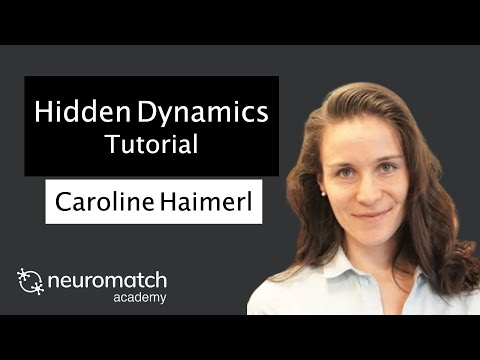

In [1]:
#@title Video 1: Introduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="6f_51L3i5aQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
# Tutorial Objectives

In the previous tutorial we gained intuition for the Kalman filter in one dimension. In this tutorial, we will examine the **two-dimensional** Kalman filter and more of its mathematical foundations.

In this tutorial, you will:
* Review linear dynamical systems
* Implement the Kalman filter
* Explore how the Kalman filter can be used to smooth data from an eye-tracking experiment

In [2]:
import sys

In [3]:
# Install PyKalman (https://pykalman.github.io/)
!pip install pykalman --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pykalman
from scipy import stats

In [4]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
#@title Data retrieval and loading
import io
import os
import hashlib
import requests

fname = "W2D3_mit_eyetracking_2009.npz"
url = "https://osf.io/jfk8w/download"
expected_md5 = "20c7bc4a6f61f49450997e381cf5e0dd"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_eyetracking_data(data_fname=fname):

  with np.load(data_fname, allow_pickle=True) as dobj:
    data = dict(**dobj)

  images = [plt.imread(io.BytesIO(stim), format='JPG')
            for stim in data['stimuli']]
  subjects = data['subjects']

  return subjects, images

In [6]:
#@title Helper functions
np.set_printoptions(precision=3)


def plot_kalman(state, observation, estimate=None, label='filter', color='r-',
                title='LDS', axes=None):
    if axes is None:
      fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
      ax1.plot(state[:, 0], state[:, 1], 'g-', label='true latent')
      ax1.plot(observation[:, 0], observation[:, 1], 'k.', label='data')
    else:
      ax1, ax2 = axes

    if estimate is not None:
      ax1.plot(estimate[:, 0], estimate[:, 1], color=color, label=label)
    ax1.set(title=title, xlabel='X position', ylabel='Y position')
    ax1.legend()

    if estimate is None:
      ax2.plot(state[:, 0], observation[:, 0], '.k', label='dim 1')
      ax2.plot(state[:, 1], observation[:, 1], '.', color='grey', label='dim 2')
      ax2.set(title='correlation', xlabel='latent', ylabel='measured')
    else:
      ax2.plot(state[:, 0], estimate[:, 0], '.', color=color,
               label='latent dim 1')
      ax2.plot(state[:, 1], estimate[:, 1], 'x', color=color,
               label='latent dim 2')
      ax2.set(title='correlation',
              xlabel='real latent',
              ylabel='estimated latent')
    ax2.legend()

    return ax1, ax2


def plot_gaze_data(data, img=None, ax=None):
    # overlay gaze on stimulus
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    xlim = None
    ylim = None
    if img is not None:
        ax.imshow(img, aspect='auto')
        ylim = (img.shape[0], 0)
        xlim = (0, img.shape[1])

    ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
    ax.set(xlim=xlim, ylim=ylim)

    return ax


def plot_kf_state(kf, data, ax):
    mu_0 = np.ones(kf.n_dim_state)
    mu_0[:data.shape[1]] = data[0]
    kf.initial_state_mean = mu_0

    mu, sigma = kf.smooth(data)
    ax.plot(mu[:, 0], mu[:, 1], 'limegreen', linewidth=3, zorder=1)
    ax.scatter(mu[0, 0], mu[0, 1], c='orange', marker='>', s=200, zorder=2)
    ax.scatter(mu[-1, 0], mu[-1, 1], c='orange', marker='s', s=200, zorder=2)

---
# Section 1: Linear Dynamical System (LDS)

Video available at https://youtu.be/2SWh639YgEg


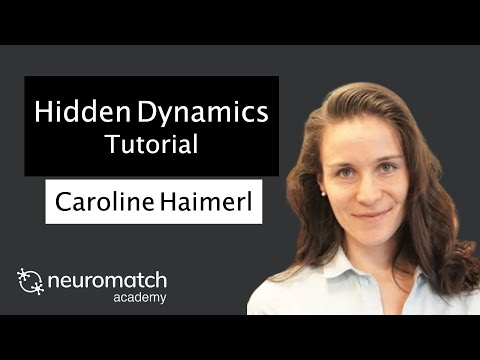

In [7]:
#@title Video 2: Linear Dynamical Systems
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2SWh639YgEg", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Kalman filter definitions:

The latent state $s_t$ evolves as a stochastic linear dynamical system in discrete time, with a dynamics matrix $D$:

\begin{equation}
s_t = Ds_{t-1}+w_t
\end{equation}

Just as in the HMM, the structure is a Markov chain where the state at time point $t$ is conditionally independent of previous states given the state at time point $t-1$.

Sensory measurements $m_t$ (observations) are noisy linear projections of the latent state:

\begin{equation}
m_t = Hs_{t}+\eta_t
\end{equation}

Both states and measurements have Gaussian variability, often called noise: 'process noise' $w_t$ for the states, and 'measurement' or 'observation noise' $\eta_t$ for the measurements. The initial state is also Gaussian distributed. These quantites have means and covariances:

\begin{eqnarray}
w_t & \sim & \mathcal{N}(0, Q) \\
\eta_t & \sim & \mathcal{N}(0, R) \\
s_0 & \sim & \mathcal{N}(\mu_0, \Sigma_0)
\end{eqnarray}

As a consequence, $s_t$, $m_t$ and their joint distributions are Gaussian. This makes all of the math analytically tractable using linear algebra, so we can easily compute the marginal and conditional distributions we will use for inferring the current state given the entire history of measurements.

_**Please note**: we are trying to create uniform notation across tutorials. In some videos created in 2020, measurements $m_t$ were denoted $y_t$, and the Dynamics matrix $D$ was denoted $F$. We apologize for any confusion!_

## Section 1.1: Sampling from a latent linear dynamical system

The first thing we will investigate is how to generate timecourse samples from a linear dynamical system given its parameters. We will start by defining the following system:

In [8]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

# initialize model parameters
params = {
  'D': 0.9 * np.eye(n_dim_state),  # state transition matrix
  'Q': np.eye(n_dim_obs),  # state noise covariance
  'H': np.eye(n_dim_state),  # observation matrix
  'R': 1.0 * np.eye(n_dim_obs),  # observation noise covariance
  'mu_0': np.zeros(n_dim_state),  # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
}

**Coding note**: We used a parameter dictionary `params` above. As the number of parameters we need to provide to our functions increases, it can be beneficial to condense them into a data structure like this to clean up the number of inputs we pass in. The trade-off is that we have to know what is in our data structure to use those values, rather than looking at the function signature directly.

### Exercise 1: Sampling from a linear dynamical system

In this exercise you will implement the dynamics functions of a linear dynamical system to sample both a latent space trajectory (given parameters set above) and noisy measurements.


sample at t=3  [3.286 0.527]


(<AxesSubplot:title={'center':'sample'}, xlabel='X position', ylabel='Y position'>,
 <AxesSubplot:title={'center':'correlation'}, xlabel='latent', ylabel='measured'>)

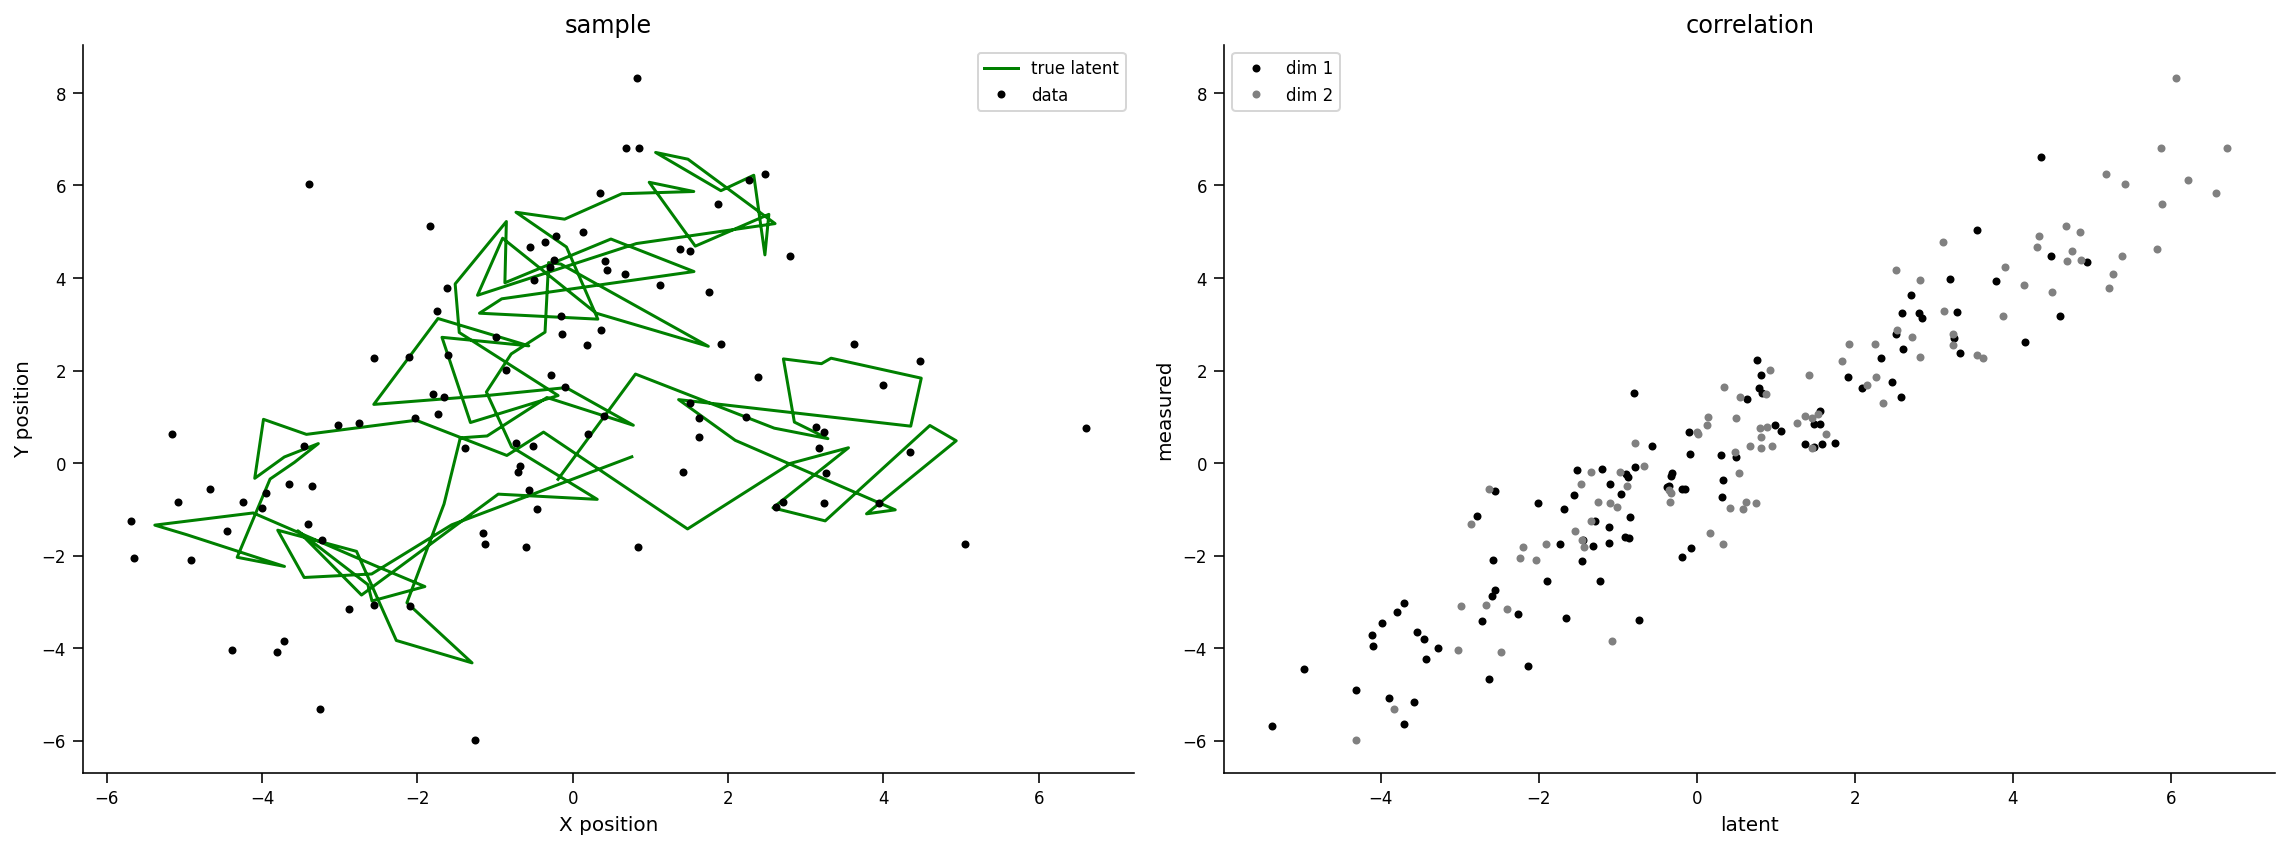

In [14]:
def sample_lds(n_timesteps, params, seed=0):
  """ Generate samples from a Linear Dynamical System specified by the provided
  parameters.

  Args:
  n_timesteps (int): the number of time steps to simulate
  params (dict): a dictionary of model parameters: (D, Q, H, R, mu_0, sigma_0)
  seed (int): a random seed to use for reproducibility checks

  Returns:
  ndarray, ndarray: the generated state and observation data
  """
  n_dim_state = params['D'].shape[0]
  n_dim_obs = params['H'].shape[0]

  # set seed
  np.random.seed(seed)

  # precompute random samples from the provided covariance matrices
  # mean defaults to 0
  mi = stats.multivariate_normal(cov=params['Q']).rvs(n_timesteps)
  eta = stats.multivariate_normal(cov=params['R']).rvs(n_timesteps)

  # initialize state and observation arrays
  state = np.zeros((n_timesteps, n_dim_state))
  obs = np.zeros((n_timesteps, n_dim_obs))

  ###################################################################
  # for students: compute the next state and observation values
  # Fill out function and remove
  ###################################################################

  # simulate the system
  for t in range(n_timesteps):
    # write the expressions for computing state values given the time step
    if t == 0:
      state[t] = stats.multivariate_normal(mean=params['mu_0'],
                                           cov=params['sigma_0']).rvs(1)
    else:
      state[t] = params['D'] @ state[t-1] + mi[t]

    # write the expression for computing the observation
    obs[t] = params['H'] @ state[t] + eta[t]

  return state, obs


# Uncomment below to test your function
state, obs = sample_lds(100, params)
print('sample at t=3 ', state[3])
plot_kalman(state, obs, title='sample')

### Interactive Demo: Adjusting System Dynamics
To test your understanding of the parameters of a linear dynamical system, think about what you would expect if you made the following changes:
1. Reduce observation noise $R$
2. Increase respective temporal dynamics $D$

Use the interactive widget below to vary the values of $R$ and $D$.

In [16]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(R=widgets.FloatLogSlider(1., min=-2, max=2),
                  D=widgets.FloatSlider(0.9, min=0.0, max=1.0, step=.01))
def explore_dynamics(R=0.1, D=0.5):
    params = {
    'D': D * np.eye(n_dim_state),  # state transition matrix
    'Q': np.eye(n_dim_obs),  # state noise covariance
    'H': np.eye(n_dim_state),  # observation matrix
    'R': R * np.eye(n_dim_obs),  # observation noise covariance
    'mu_0': np.zeros(n_dim_state),  # initial state mean,
    'sigma_0': 0.1 * np.eye(n_dim_state),  # initial state noise covariance
    }

    state, obs = sample_lds(100, params)
    plot_kalman(state, obs, title='sample')

interactive(children=(FloatLogSlider(value=1.0, description='R', max=2.0, min=-2.0), FloatSlider(value=0.9, de…

---
# Section 2: Kalman Filtering


Video available at https://youtu.be/VboZOV9QMOI


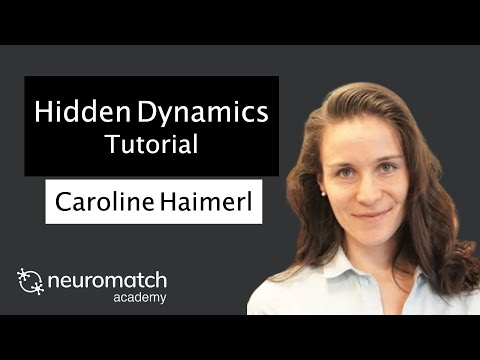

In [17]:
#@title Video 3: Kalman Filtering
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VboZOV9QMOI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

We want to infer the latent state variable $s_t$ given the measured (observed) variable $m_t$.

\begin{equation}
P(s_t|m_1, ..., m_t, m_{t+1}, ..., m_T)\sim \mathcal{N}(\hat{\mu}_t, \hat{\Sigma_t})
\end{equation}

First we obtain estimates of the latent state by running the filtering from $t=0,....T$.

\begin{equation}
s_t^{\rm pred}\sim \mathcal{N}(\hat{\mu}_t^{\rm pred},\hat{\Sigma}_t^{\rm pred})\end{equation}

Where $\hat{\mu}_t^{\rm pred}$ and $\hat{\Sigma}_t^{\rm pred}$ are derived as follows:

\begin{eqnarray}
\hat{\mu}_1^{\rm pred} & = & D\hat{\mu}_{0} \\
\hat{\mu}_t^{\rm pred} & = & D\hat{\mu}_{t-1}
\end{eqnarray}

This is the prediction for $s_t$ obtained simply by taking the expected value of $s_{t-1}$ and projecting it forward one step using the transition matrix $D$.
We do the same for the covariance, taking into account the noise covariance $Q$ and the fact that scaling a variable by $D$ scales its covariance $\Sigma$ as $D\Sigma D^T$:

\begin{eqnarray}
\hat{\Sigma}_0^{\rm pred} & = & D\hat{\Sigma}_{0}D^T+Q \\
\hat{\Sigma}_t^{\rm pred} & = & D\hat{\Sigma}_{t-1}D^T+Q
\end{eqnarray}


We then use a Bayesian update from the newest measurements to obtain $\hat{\mu}_t^{\rm filter}$ and $\hat{\Sigma}_t^{\rm filter}$

Project our prediction to observational space:

\begin{equation}
m_t^{\rm pred}\sim \mathcal{N}(H\hat{\mu}_t^{\rm pred}, H\hat{\Sigma}_t^{\rm pred}H^T+R)
\end{equation}

update prediction by actual data:

\begin{eqnarray}
s_t^{\rm filter} & \sim & \mathcal{N}(\hat{\mu}_t^{\rm filter}, \hat{\Sigma}_t^{\rm filter}) \\
\hat{\mu}_t^{\rm filter} & = & \hat{\mu}_t^{\rm pred}+K_t(m_t-H\hat{\mu}_t^{\rm pred}) \\
\hat{\Sigma}_t^{\rm filter} & = & (I-K_tH)\hat{\Sigma}_t^{\rm pred}
\end{eqnarray}

Kalman gain matrix: 
\begin{equation}
K_t=\hat{\Sigma}_t^{\rm pred}H^T(H\hat{\Sigma}_t^{\rm pred}H^T+R)^{-1}
\end{equation}

We use the latent-only prediction to project it to the observational space and compute a correction proportional to the error $m_t-HDz_{t-1}$ between prediction and data. The coefficient of this correction is the Kalman gain matrix.

**Interpretations**

If measurement noise is small and dynamics are fast, then estimation will depend mostly on currently observed data.
If the measurement noise is large, then the Kalman filter uses past observations as well, combining them as long as the underlying state is at least somewhat predictable.

In order to explore the impact of filtering, we will use the following noisy oscillatory system:

(<AxesSubplot:title={'center':'sample'}, xlabel='X position', ylabel='Y position'>,
 <AxesSubplot:title={'center':'correlation'}, xlabel='latent', ylabel='measured'>)

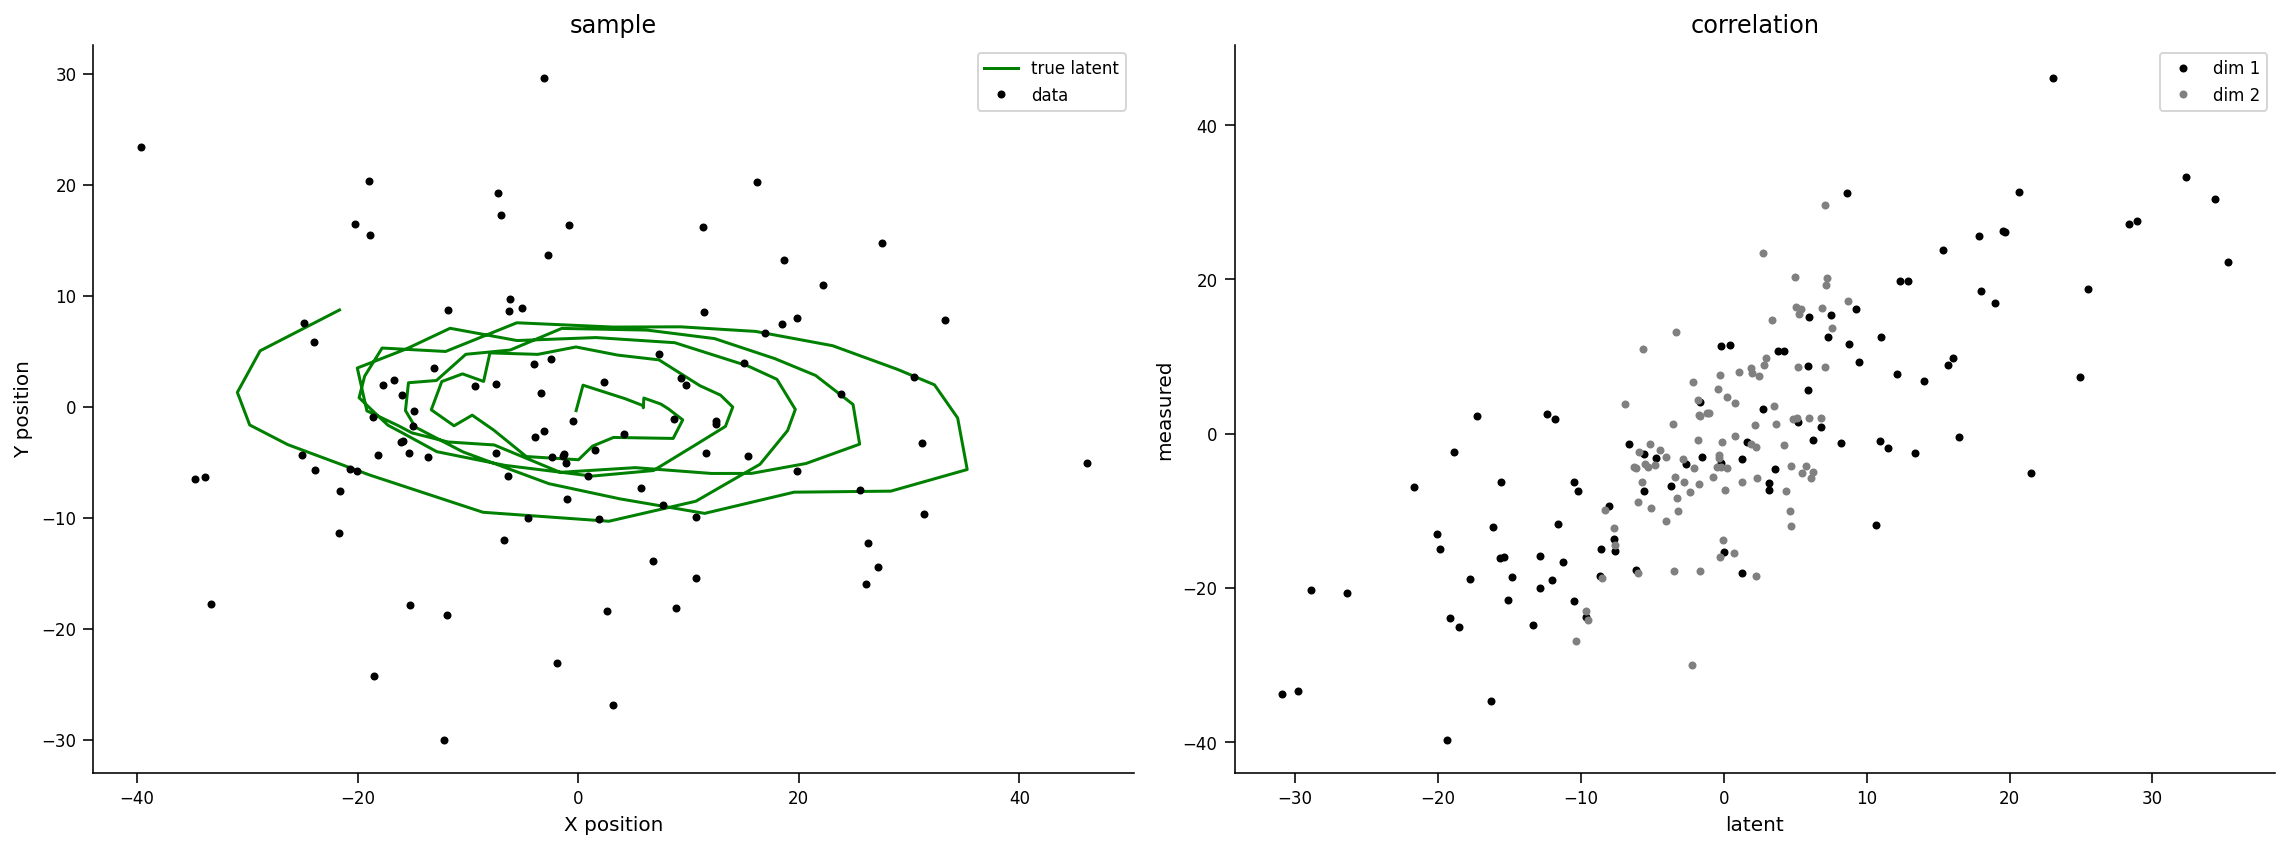

In [18]:
# task dimensions
n_dim_state = 2
n_dim_obs = 2

T=100

# initialize model parameters
params = {
  'D': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]),  # state transition matrix
  'Q': np.eye(n_dim_obs),                               # state noise covariance
  'H': np.eye(n_dim_state),                             # observation matrix
  'R': 100.0 * np.eye(n_dim_obs),                       # observation noise covariance
  'mu_0': np.zeros(n_dim_state),                        # initial state mean
  'sigma_0': 0.1 * np.eye(n_dim_state),                 # initial state noise covariance
}

state, obs = sample_lds(T, params)
plot_kalman(state, obs, title='sample')

## Exercise 2: Implement Kalman filtering
In this exercise you will implement the Kalman filter (forward) process. Your focus will be on writing the expressions for the Kalman gain, filter mean, and filter covariance at each time step (refer to the equations above).

(<AxesSubplot:title={'center':'my kf-filter'}, xlabel='X position', ylabel='Y position'>,
 <AxesSubplot:title={'center':'correlation'}, xlabel='real latent', ylabel='estimated latent'>)

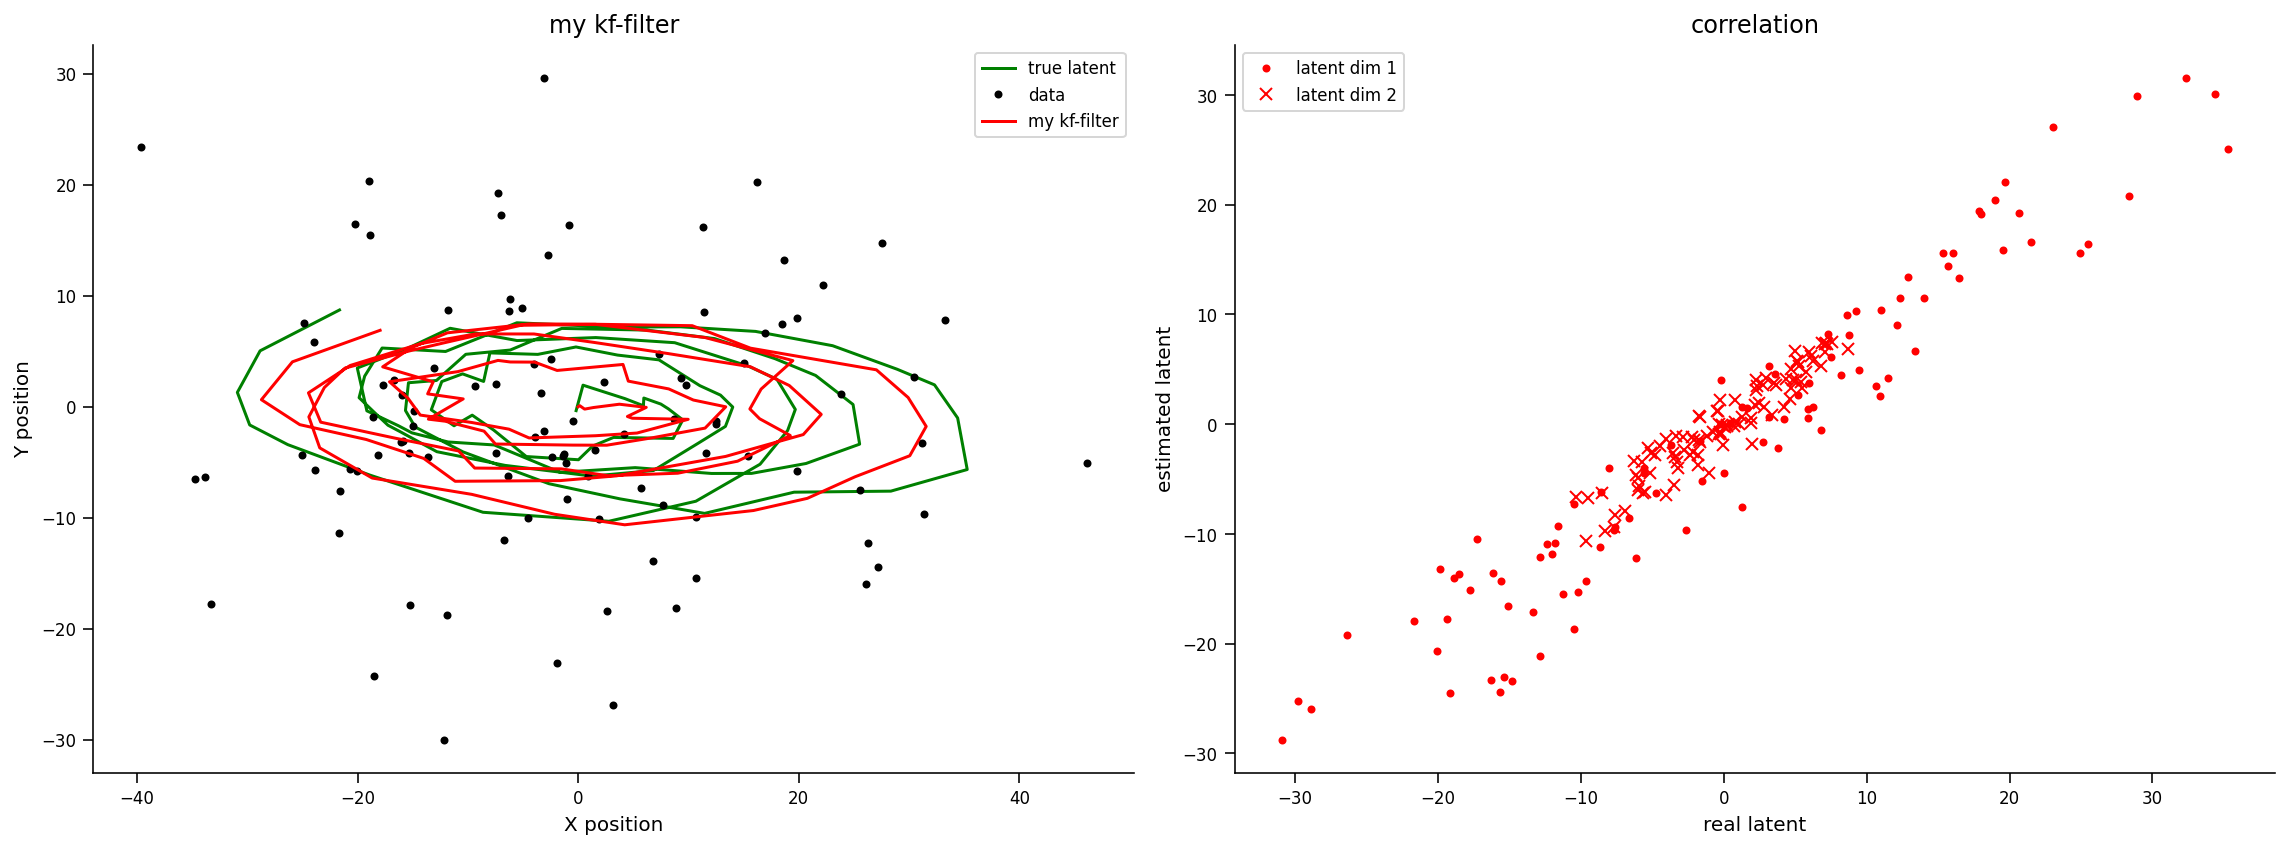

In [25]:
def kalman_filter(data, params):
  """ Perform Kalman filtering (forward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of observations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model parameters: (D, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the filtered system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  D = params['D']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = D.shape[0]
  n_dim_obs = H.shape[0]
  I = np.eye(n_dim_state)  # identity matrix

  # state tracking arrays
  mu = np.zeros((len(data), n_dim_state))
  sigma = np.zeros((len(data), n_dim_state, n_dim_state))

  # filter the data
  for t, y in enumerate(data):
    if t == 0:
      mu_pred = params['mu_0']
      sigma_pred = params['sigma_0']
    else:
      mu_pred = D @ mu[t-1]
      sigma_pred = D @ sigma[t-1] @ D.T + Q

    ###########################################################################
    # for students: compute the filtered state mean and covariance values
    # Fill out function and remove
    ###########################################################################
    # write the expression for computing the Kalman gain
    K = sigma_pred @ H.T @ np.linalg.inv(H @ sigma_pred @ H.T +R)
    # write the expression for computing the filtered state mean
    mu[t] = mu_pred + K @ (y - H @ mu_pred)
    # write the expression for computing the filtered state noise covariance
    sigma[t] = (I - K @ H) @ sigma_pred

  return mu, sigma


# Uncomment below to test your function
filtered_state_means, filtered_state_covariances = kalman_filter(obs, params)
plot_kalman(state, obs, filtered_state_means, title="my kf-filter",
             color='r', label='my kf-filter')

---
# Section 3: Fitting Eye Gaze Data

In [ ]:
#@title Video 4: Fitting Eye Gaze Data
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="M7OuXmVWHGI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Tracking eye gaze is used in both experimental and user interface applications. Getting an accurate estimation of where someone is looking on a screen in pixel coordinates can be challenging, however, due to the various sources of noise inherent in obtaining these measurements. A main source of noise is the general accuracy of the eye tracker device itself and how well it maintains calibration over time. Changes in ambient light or subject position can further reduce accuracy of the sensor. Eye blinks introduce a different form of noise as interruptions in the data stream which also need to be addressed.

Fortunately we have a candidate solution for handling noisy eye gaze data in the Kalman filter we just learned about. Let's look at how we can apply these methods to a small subset of data taken from the [MIT Eyetracking Database](http://people.csail.mit.edu/tjudd/WherePeopleLook/index.html) [[Judd et al. 2009](http://people.csail.mit.edu/tjudd/WherePeopleLook/Docs/wherepeoplelook.pdf)]. This data was collected as part of an effort to model [visual saliency](http://www.scholarpedia.org/article/Visual_salience) -- given an image, can we predict where a person is most likely going to look.

In [26]:
# load eyetracking data
subjects, images = load_eyetracking_data()

## Interactive Demo: Tracking Eye Gaze

We have three stimulus images and five different subjects' gaze data. Each subject fixated in the center of the screen before the image appeared, then had a few seconds to freely look around. You can use the widget below to see how different subjects visually scanned the presented image. A subject ID of -1 will show the stimulus images without any overlayed gaze trace. 

Note that the images are rescaled below for display purposes, they were in their original aspect ratio during the task itself.

In [27]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(subject_id=widgets.IntSlider(-1, min=-1, max=4),
                  image_id=widgets.IntSlider(0, min=0, max=2))
def plot_subject_trace(subject_id=-1, image_id=0):
  if subject_id == -1:
    subject = np.zeros((3, 0, 2))
  else:
    subject = subjects[subject_id]
  data = subject[image_id]
  img = images[image_id]

  fig, ax = plt.subplots()
  ax.imshow(img, aspect='auto')
  ax.scatter(data[:, 0], data[:, 1], c='m', s=100, alpha=0.7)
  ax.set(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))

interactive(children=(IntSlider(value=-1, description='subject_id', max=4, min=-1), IntSlider(value=0, descrip…

## Section 3.1: Fitting data with `pykalman`

Now that we have data, we'd like to use Kalman filtering to give us a better estimate of the true gaze. Up until this point we've known the parameters of our LDS, but here we need to estimate them from data directly. We will use the `pykalman` package to handle this estimation using the EM algorithm, a useful and influential learning algorithm described briefly in the bonus material.

Before exploring fitting models with `pykalman` it's worth pointing out some naming conventions used by the library:

\begin{align}
D &: \texttt{transition_matrices} & 
Q &: \texttt{transition_covariance} \\
H &: \texttt{observation_matrices} &
R &: \texttt{observation_covariance} \\
\mu_0 &: \texttt{initial_state_mean} & \Sigma_0 &: \texttt{initial_state_covariance}
\end{align}

The first thing we need to do is provide a guess at the dimensionality of the latent state. Let's start by assuming the dynamics line-up directly with the observation data (pixel x,y-coordinates), and so we have a state dimension of 2.

We also need to decide which parameters we want the EM algorithm to fit. In this case, we will let the EM algorithm discover the dynamics parameters i.e. the $D$, $Q$, $H$, and $R$ matrices.

We set up our `pykalman` `KalmanFilter` object with these settings using the code below.

In [28]:
# set up our KalmanFilter object and tell it which parameters we want to
# estimate
np.random.seed(1)

n_dim_obs = 2
n_dim_state = 2

kf = pykalman.KalmanFilter(
  n_dim_state=n_dim_state,
  n_dim_obs=n_dim_obs,
  em_vars=['transition_matrices', 'transition_covariance',
           'observation_matrices', 'observation_covariance']
)

Because we know from the reported experimental design that subjects fixated in the center of the screen right before the image appears, we can set the initial starting state estimate $\mu_0$ as being the center pixel of the stimulus image (the first data point in this sample dataset) with a correspondingly low initial noise covariance $\Sigma_0$. Once we have everything set, it's time to fit some data.

In [29]:
# Choose a subject and stimulus image
subject_id = 1
image_id = 2
data = subjects[subject_id][image_id]

# Provide the initial states
kf.initial_state_mean = data[0]
kf.initial_state_covariance = 0.1*np.eye(n_dim_state)

# Estimate the parameters from data using the EM algorithm
kf.em(data)

print(f'D=\n{kf.transition_matrices}')
print(f'Q =\n{kf.transition_covariance}')
print(f'H =\n{kf.observation_matrices}')
print(f'R =\n{kf.observation_covariance}')

D=
[[ 1.004 -0.01 ]
 [ 0.005  0.989]]
Q =
[[278.016 219.292]
 [219.292 389.774]]
H =
[[ 0.999  0.003]
 [-0.004  1.01 ]]
R =
[[26.026 19.596]
 [19.596 26.745]]


We see that the EM algorithm has found fits for the various dynamics parameters. One thing you will note is that both the state and observation matrices are close to the identity matrix, which means the x- and y-coordinate dynamics are independent of each other and primarily impacted by the noise covariances.

We can now use this model to smooth the observed data from the subject. In addition to the source image, we can also see how this model will work with the gaze recorded by the same subject on the other images as well, or even with different subjects.

Below are the three stimulus images overlayed with recorded gaze in magenta and smoothed state from the filter in green, with gaze begin (orange triangle) and gaze end (orange square) markers. 

In [30]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(subject_id=widgets.IntSlider(1, min=0, max=4))
def plot_smoothed_traces(subject_id=0):
  subject = subjects[subject_id]
  fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
  for data, img, ax in zip(subject, images, axes):
    ax = plot_gaze_data(data, img=img, ax=ax)
    plot_kf_state(kf, data, ax)

interactive(children=(IntSlider(value=1, description='subject_id', max=4), Output()), _dom_classes=('widget-in…

## Discussion questions:

Why do you think one trace from one subject was sufficient to provide a decent fit across all subjects? If you were to go back and change the subject_id and/or image_id for when we fit the data using EM, do you think the fits would be different?

We don't think the eye is exactly following a linear dynamical system. Nonetheless that is what we assumed for this exercise when we applied a Kalman filter. Despite the mismatch, these algorithms do perform well. Discuss what differences we might find between the true and assumed processes. What mistakes might be likely consequences of these differences?

Finally, recall that the original task was to use this data to help develop models of visual salience. While our Kalman filter is able to provide smooth estimates of observed gaze data, it's not telling us anything about *why* the gaze is going in a certain direction. In fact, if we sample data from our parameters and plot them, we get what amounts to a random walk.

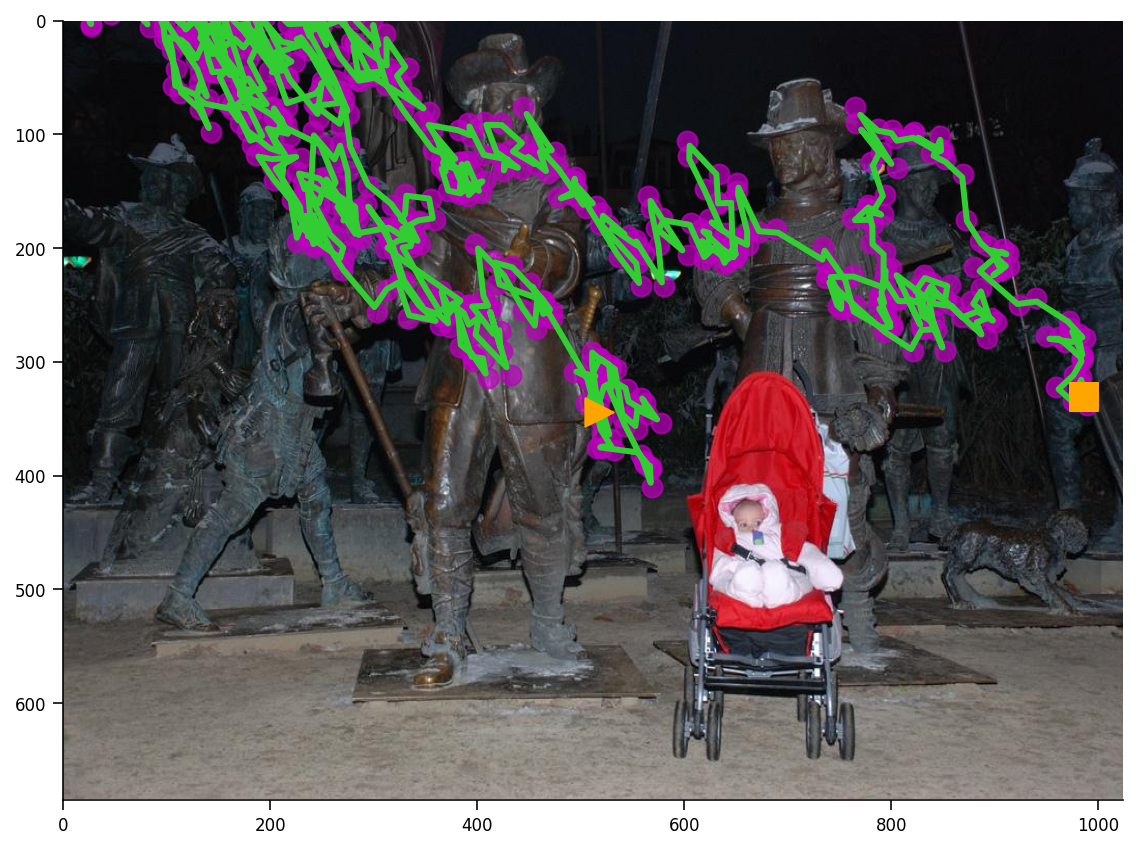

In [31]:
kf_state, kf_data = kf.sample(len(data))
ax = plot_gaze_data(kf_data, img=images[2])
plot_kf_state(kf, kf_data, ax)

This should not be surprising, as we have given the model no other observed data beyond the pixels at which gaze was detected. We expect there is some other aspect driving the latent state of where to look next other than just the previous fixation location.

In summary, while the Kalman filter is a good option for smoothing the gaze trajectory itself, especially if using a lower-quality eye tracker or in noisy environmental conditions, a linear dynamical system may not be the right way to approach the much more challenging task of modeling visual saliency.


## Handling Eye Blinks

In the MIT Eyetracking Database, raw tracking data includes times when the subject blinked. The way this is represented in the data stream is via negative pixel coordinate values.

We could try to mitigate these samples by simply deleting them from the stream, though this introduces other issues. For instance, if each sample corresponds to a fixed time step, and you arbitrarily remove some samples, the integrity of that consistent timestep between samples is lost. It's sometimes better to flag data as missing rather than to pretend it was never there at all, especially with time series data.

Another solution is to use masked arrays. In `numpy`, a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html#what-is-a-masked-array) is an `ndarray` with an additional embedded boolean masking array that indicates which elements should be masked. When computation is performed on the array, the masked elements are ignored. Both `matplotlib` and `pykalman` work with masked arrays, and, in fact, this is the approach taken with the data we explore in this notebook. 

In preparing the dataset for this notebook, the original dataset was preprocessed to set all gaze data as masked arrays, with the mask enabled for any pixel with a negative x or y coordinate.



# Bonus

## Review on Gaussian joint, marginal and conditional distributions

Assume

\begin{eqnarray}
z & = & \begin{bmatrix}x \\y\end{bmatrix}\sim N\left(\begin{bmatrix}a \\b\end{bmatrix}, \begin{bmatrix}A & C \\C^T & B\end{bmatrix}\right)
\end{eqnarray}

then the marginal distributions are

\begin{eqnarray}
x & \sim & \mathcal{N}(a, A) \\
y & \sim & \mathcal{N}(b,B)
\end{eqnarray}

and the conditional distributions are

\begin{eqnarray}
x|y & \sim & \mathcal{N}(a+CB^{-1}(y-b), A-CB^{-1}C^T) \\
y|x & \sim & \mathcal{N}(b+C^TA^{-1}(x-a), B-C^TA^{-1}C)
\end{eqnarray}

*important take away: given the joint Gaussian distribution we can derive the conditionals*

## Kalman Smoothing

Video available at https://youtu.be/4Ar2mYz1Nms


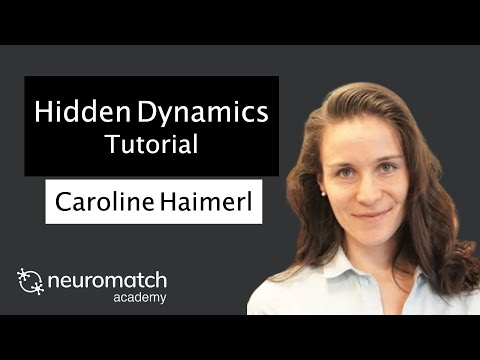

In [32]:
#@title Video 5: Kalman Smoothing and the EM Algorithm
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="4Ar2mYz1Nms", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Obtain estimates by propagating from $y_T$ back to $y_0$ using results of forward pass ($\hat{\mu}_t^{\rm filter}, \hat{\Sigma}_t^{\rm filter}, P_t=\hat{\Sigma}_{t+1}^{\rm pred}$)

\begin{eqnarray}
s_t & \sim & \mathcal{N}(\hat{\mu}_t^{\rm smooth}, \hat{\Sigma}_t^{\rm smooth}) \\
\hat{\mu}_t^{\rm smooth} & = & \hat{\mu}_t^{\rm filter}+J_t(\hat{\mu}_{t+1}^{\rm smooth}-D\hat{\mu}_t^{\rm filter}) \\
\hat{\Sigma}_t^{\rm smooth} & = & \hat{\Sigma}_t^{\rm filter}+J_t(\hat{\Sigma}_{t+1}^{\rm smooth}-P_t)J_t^T \\
J_t & = & \hat{\Sigma}_t^{\rm filter}D^T P_t^{-1}
\end{eqnarray}

This gives us the final estimate for $z_t$.

\begin{eqnarray}
\hat{\mu}_t & = & \hat{\mu}_t^{\rm smooth} \\
\hat{\Sigma}_t & = & \hat{\Sigma}_t^{\rm smooth}
\end{eqnarray}

### Exercise 3: Implement Kalman smoothing

In this exercise you will implement the Kalman smoothing (backward) process. Again you will focus on writing the expressions for computing the smoothed mean, smoothed covariance, and $J_t$ values.

(<AxesSubplot:title={'center':'LDS'}, xlabel='X position', ylabel='Y position'>,
 <AxesSubplot:title={'center':'correlation'}, xlabel='real latent', ylabel='estimated latent'>)

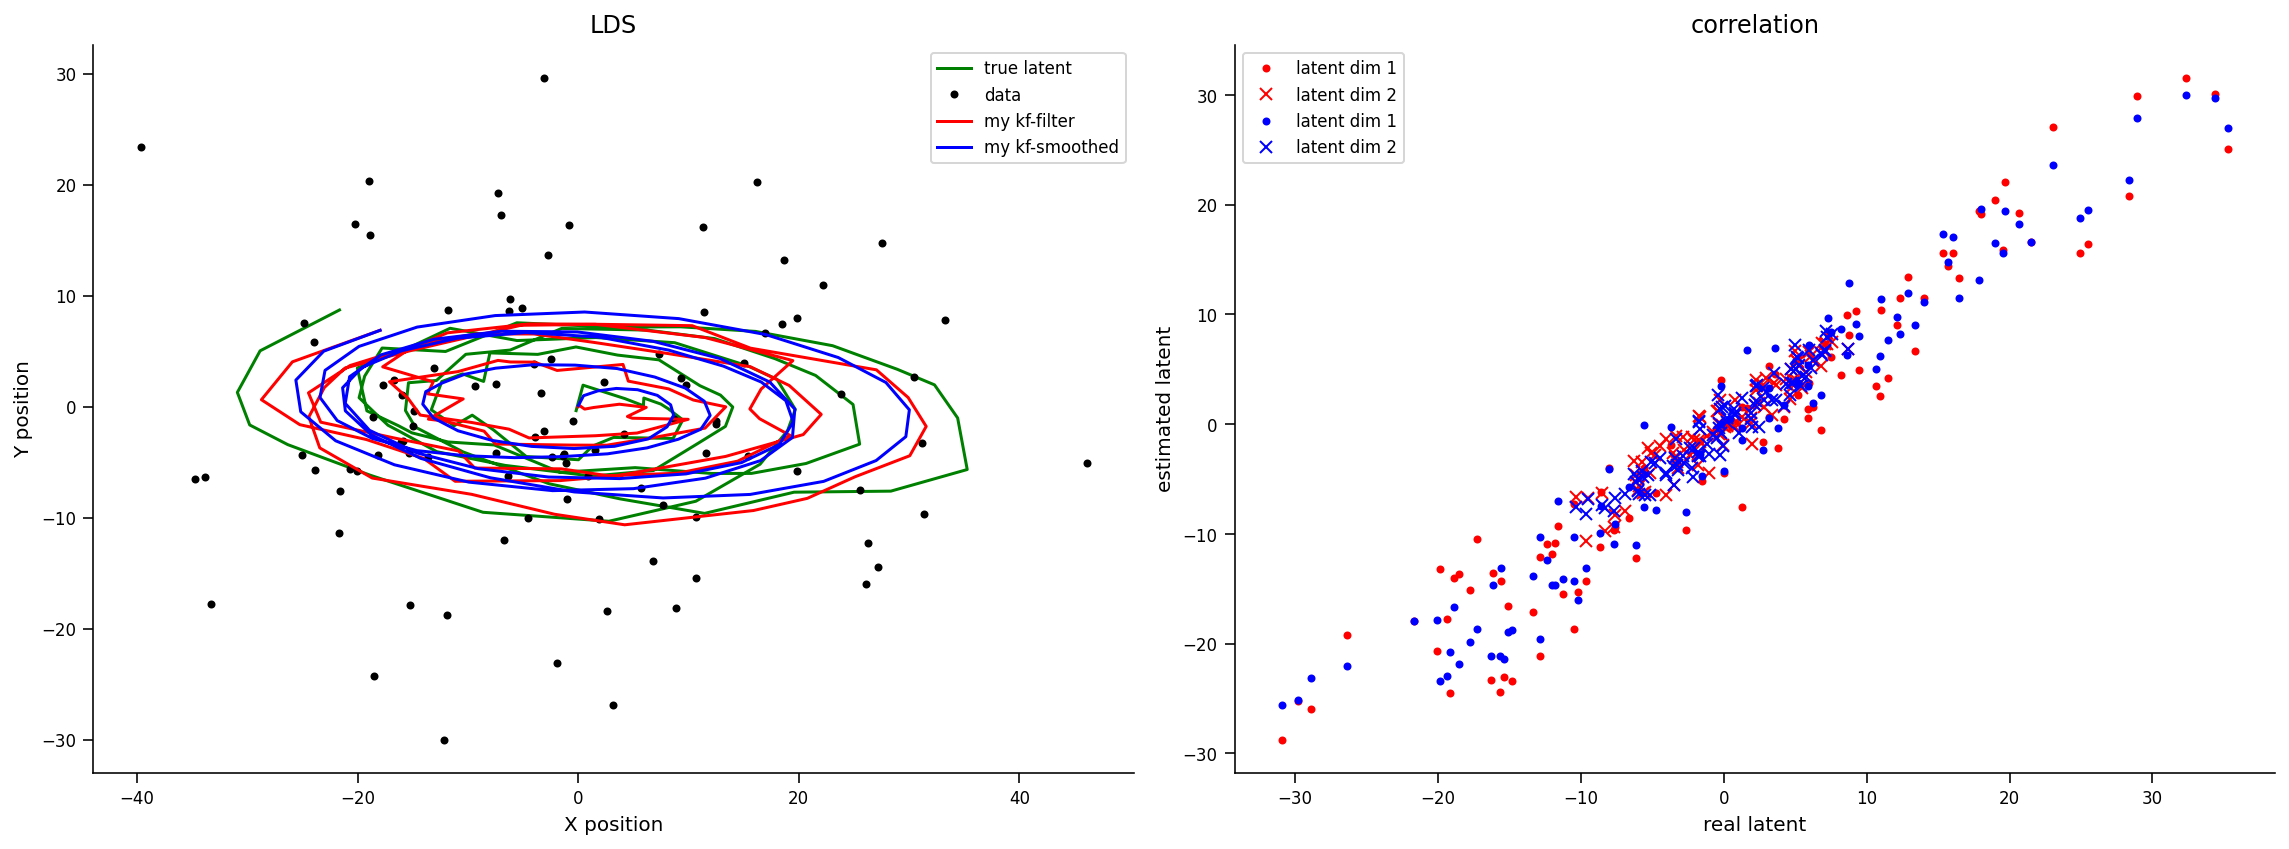

In [34]:
def kalman_smooth(data, params):
  """ Perform Kalman smoothing (backward pass) on the data given the provided
  system parameters.

  Args:
    data (ndarray): a sequence of observations of shape(n_timesteps, n_dim_obs)
    params (dict): a dictionary of model parameters: (D, Q, H, R, mu_0, sigma_0)

  Returns:
    ndarray, ndarray: the smoothed system means and noise covariance values
  """
  # pulled out of the params dict for convenience
  D= params['D']
  Q = params['Q']
  H = params['H']
  R = params['R']

  n_dim_state = D.shape[0]
  n_dim_obs = H.shape[0]

  # first run the forward pass to get the filtered means and covariances
  mu, sigma = kalman_filter(data, params)

  # initialize state mean and covariance estimates
  mu_hat = np.zeros_like(mu)
  sigma_hat = np.zeros_like(sigma)
  mu_hat[-1] = mu[-1]
  sigma_hat[-1] = sigma[-1]

  # smooth the data
  for t in reversed(range(len(data)-1)):
    sigma_pred = D@ sigma[t] @ D.T + Q  # sigma_pred at t+1
    ###########################################################################
    ## for students: compute the smoothed state mean and covariance values
    # Fill out function and remove
    ###########################################################################

    # write the expression to compute the Kalman gain for the backward process
    J = sigma[t] @ D.T @ np.linalg.inv(sigma_pred)
    # write the expression to compute the smoothed state mean estimate
    mu_hat[t] = mu[t] + J @ (mu_hat[t+1] - D @ mu[t])
    # write the expression to compute the smoothed state noise covariance estimate
    sigma_hat[t] = sigma[t] + J @(sigma_hat[t+1] - sigma_pred) @ J.T

  return mu_hat, sigma_hat


# Uncomment once the kalman_smooth function is complete
smoothed_state_means, smoothed_state_covariances = kalman_smooth(obs, params)
axes = plot_kalman(state, obs, filtered_state_means, color="r",
                    label="my kf-filter")
plot_kalman(state, obs, smoothed_state_means, color="b",
             label="my kf-smoothed", axes=axes)

**Forward vs Backward**

Now that we have implementations for both, let's compare their performance by computing the MSE between the filtered (forward) and smoothed (backward) estimated states and the true latent state.

In [36]:
print(f"Filtered MSE: {np.mean((state - filtered_state_means)**2):.3f}")
print(f"Smoothed MSE: {np.mean((state - smoothed_state_means)**2):.3f}")

Filtered MSE: 10.963
Smoothed MSE: 7.087


In this example, the smoothed estimate is clearly superior to the filtered one. This makes sense as the forward pass uses only the past measurements, whereas the backward pass can use future measurement too, correcting the forward pass estimates given all the data we've collected.

So why would you ever use Kalman filtering alone, without smoothing? As Kalman filtering only depends on already observed data (i.e. the past) it can be run in a streaming, or on-line, setting. Kalman smoothing relies on future data as it were, and as such can only be applied in a batch, or off-line, setting. So use Kalman filtering if you need real-time corrections and Kalman smoothing if you are considering already-collected data.

This online case is typically what the brain faces.

## The Expectation-Maximization (EM) Algorithm

- want to maximize $\log p(m|\theta)$

- need to marginalize out latent state *(which is not tractable)*

\begin{equation}
p(m|\theta)=\int p(m,s|\theta)dz
\end{equation}

- add a probability distribution $q(s)$ which will approximate the latent state distribution 

$$\log p(m|\theta)\int_s q(s)dz$$

- can be rewritten as

\begin{equation}
\mathcal{L}(q,\theta)+KL\left(q(s)||p(s|m),\theta\right)
\end{equation}

- $\mathcal{L}(q,\theta)$ contains the joint distribution of $m$ and $s$

- $KL(q||p)$ contains the conditional distribution of $s|m$

#### Expectation step
- parameters are kept fixed
- find a good approximation $q(s)$: maximize lower bound $\mathcal{L}(q,\theta)$ with respect to $q(s)$
- (already implemented Kalman filter+smoother)

#### Maximization step
- keep distribution $q(s)$ fixed
- change parameters to maximize the lower bound $\mathcal{L}(q,\theta)$

As mentioned, we have already effectively solved for the E-Step with our Kalman filter and smoother. The M-step requires further derivation, which is covered in the Appendix. Rather than having you implement the M-Step yourselves, let's instead turn to using a library that has already implemented EM for exploring some experimental data from cognitive neuroscience.

### The M-step for a LDS

*(see Bishop, chapter 13.3.2 Learning in LDS)*
Update parameters of the probability distribution

For the updates in the M-step we will need the following posterior marginals obtained from the Kalman smoothing results* $\hat{\mu}_t^{\rm smooth}, \hat{\Sigma}_t^{\rm smooth}$

\begin{eqnarray}
E(s_t) &=& \hat{\mu}_t \\
E(s_ts_{t-1}^T) &=& J_{t-1}\hat{\Sigma}_t+\hat{\mu}_t\hat{\mu}_{t-1}^T\\
E(s_ts_{t}^T) &=& \hat{\Sigma}_t+\hat{\mu}_t\hat{\mu}_{t}^T
\end{eqnarray}

<br>

**Update parameters**

Initial parameters

\begin{eqnarray}
\mu_0^{\rm new}&=& E(s_0)\\
Q_0^{\rm new} &=& E(s_0s_0^T)-E(s_0)E(s_0^T) \\
\end{eqnarray}

<br>

Hidden (latent) state parameters

\begin{eqnarray}
D^{\rm new} &=& \left(\sum_{t=2}^N E(s_ts_{t-1}^T)\right)\left(\sum_{t=2}^N E(s_{t-1}s_{t-1}^T)\right)^{-1} \\
Q^{\rm new} &=& \frac{1}{T-1} \sum_{t=2}^N E\big(s_ts_t^T\big) - D^{\rm new}E\big(s_{t-1}s_{t}^T\big) - E\big(s_ts_{t-1}^T\big)D^{\rm new}+D^{\rm new}E\big(s_{t-1}s_{t-1}^T\big)\big(D^{\rm new}\big)^{T}\\
\end{eqnarray}

<br>

Observable (measured) space parameters

\begin{eqnarray}
H^{\rm new} &=& \left(\sum_{t=1}^N y_t E(s_t^T)\right)\left(\sum_{t=1}^N E(s_t s_t^T)\right)^{-1}\\
R^{\rm new} &=& \frac{1}{T}\sum_{t=1}^Ny_ty_t^T-H^{\rm new}E(s_t)y_t^T-y_tE(s_t^T)H^{\rm new}+H^{\rm new}E(s_ts_t^T)H_{\rm new}
\end{eqnarray}